Importamos las librerias necesarias para el funcionamiento del modelo.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Leemos el csv que exportamos desde Power BI para usarlo como nuestro DataFrame

In [13]:
sales = pd.read_csv('sales_grouped.csv')

sales.head(100)

,Total Revenue,prod_cat,prod_subcat,end_of_month
0,45309,Bags,Mens,1/31/2011 0:00
1,6136,Bags,Mens,2/28/2011 0:00
2,66436,Bags,Mens,3/31/2011 0:00
3,53873,Bags,Mens,4/30/2011 0:00
4,73058,Bags,Mens,5/31/2011 0:00
...,...,...,...,...
95,56115,Books,Academic,12/31/2012 0:00
96,40164,Books,Academic,1/31/2013 0:00
97,41161,Books,Academic,2/28/2013 0:00
98,54686,Books,Academic,3/31/2013 0:00


Creamos una copia del DataFrame para agrupar los datos mensualmente y hacer el ejercicio de estacionalidad.

Es posible también hacer ejercicio para alguna Categoria y Subcategoría en específico.

In [16]:
sales_total = sales.copy()
#sales_total = sales_total[sales_total["prod_cat"]=="Bags"]
sales_total.index = pd.to_datetime(sales_total['end_of_month'],format='%m/%d/%Y %H:%M')
st_grouped = sales_total.groupby(by=sales_total.index).sum()
st_grouped.head(50)

,Total Revenue
end_of_month,
2011-01-31,760234
2011-02-28,957106
2011-03-31,1212644
2011-04-30,1200185
2011-05-31,1022402
2011-06-30,1160470
2011-07-31,1087260
2011-08-31,1084520
2011-09-30,1325662


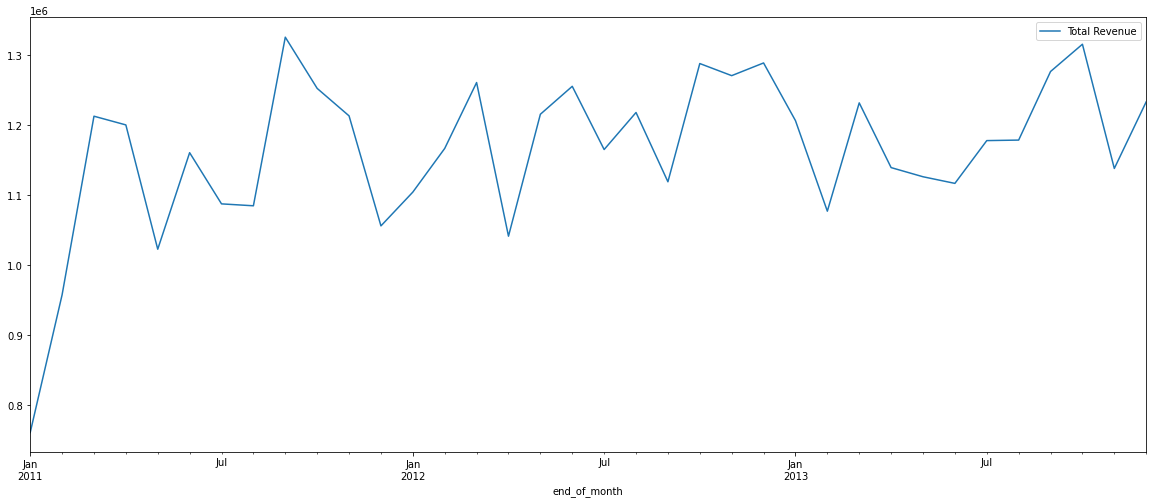

In [17]:
plt.rcParams["figure.figsize"] = (20,8)
st_grouped.plot()

Volvemos a importar librerias relevantes para el analisis estacionario y la predicción de tendencia.

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

El siguiente gráfico lo utilizaremos para analizar diferentes aspectos del histórico de ventas como: 


1.   Ventas observadas
2.   Tendencia
3.   Estacionalidad
4.   Residual



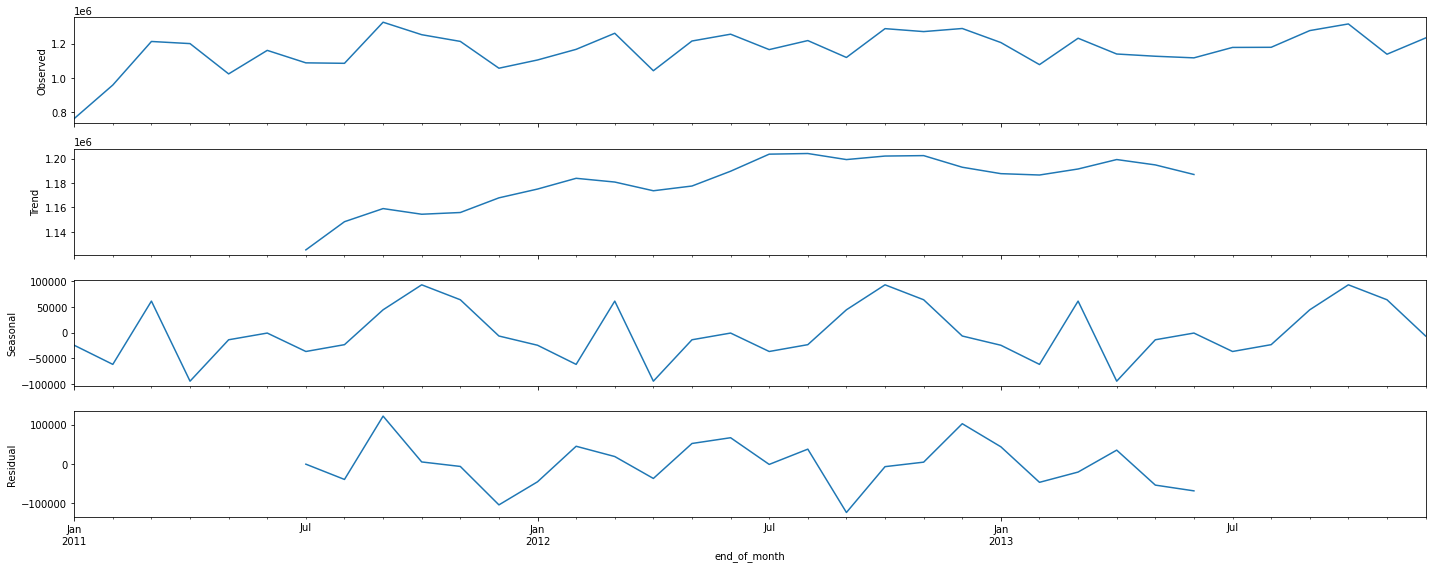

In [23]:
decompose_data = seasonal_decompose(st_grouped, model="additive")
plt.rcParams["figure.figsize"] = (20,8)
decompose_data.plot();

Vamos a hacer enfasis en la distribución estacionaria para ver en qué epocas suben y bajan las ventas.

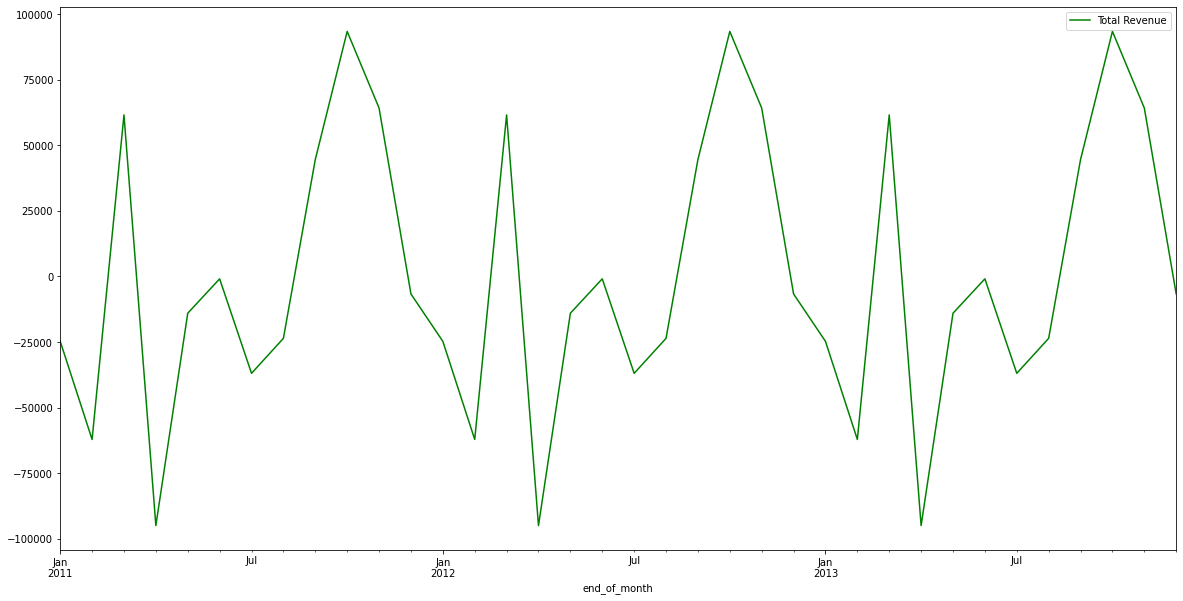

In [22]:
seasonality=decompose_data.seasonal
plt.rcParams["figure.figsize"] = (20,10)
seasonality.plot(color='green')

In [30]:
dftest = adfuller(st_grouped["Total Revenue"], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)


1. ADF :  -5.877194762139058
2. P-Value :  3.1392505188036867e-07
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 35
5. Critical Values :
	 1% :  -3.6327426647230316
	 5% :  -2.9485102040816327
	 10% :  -2.6130173469387756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


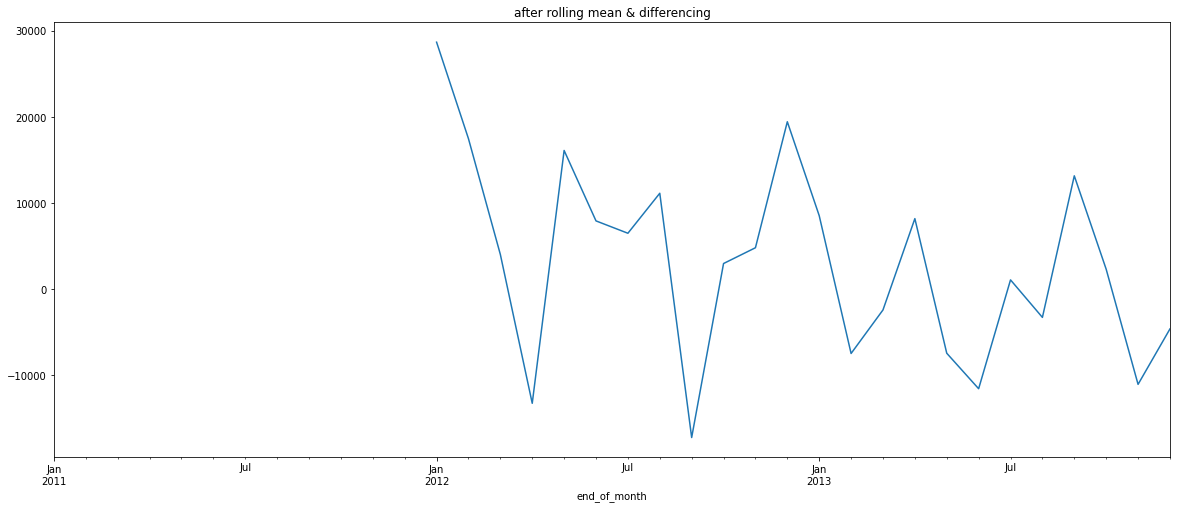

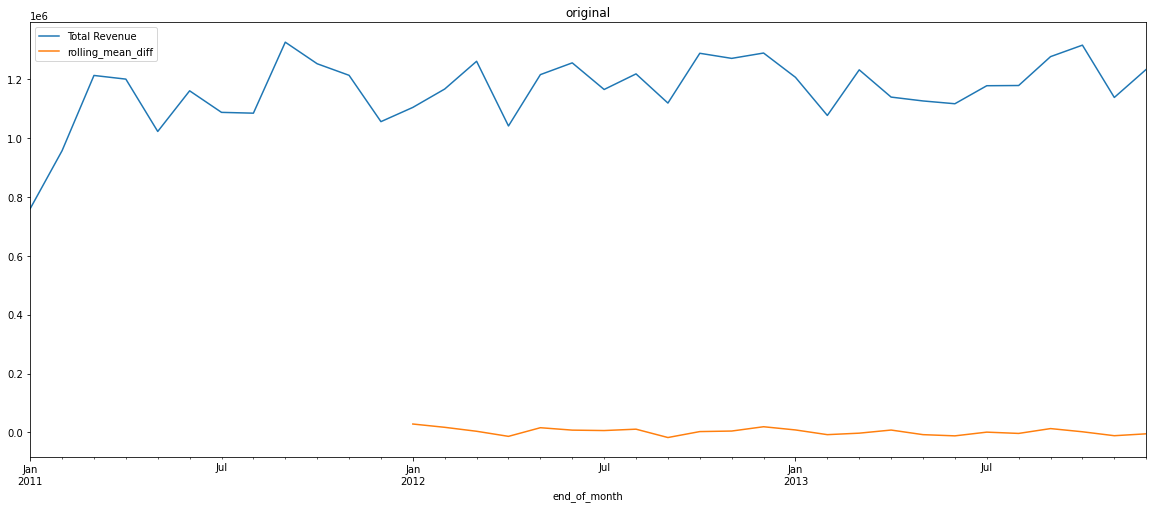

In [31]:
rolling_mean = st_grouped.rolling(window = 12).mean()
st_grouped['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
st_grouped['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
st_grouped.plot(title='original');

In [71]:
model=sm.tsa.statespace.SARIMAX(st_grouped['Total Revenue'],order=(0, 0, 0),seasonal_order=(1,1,0,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


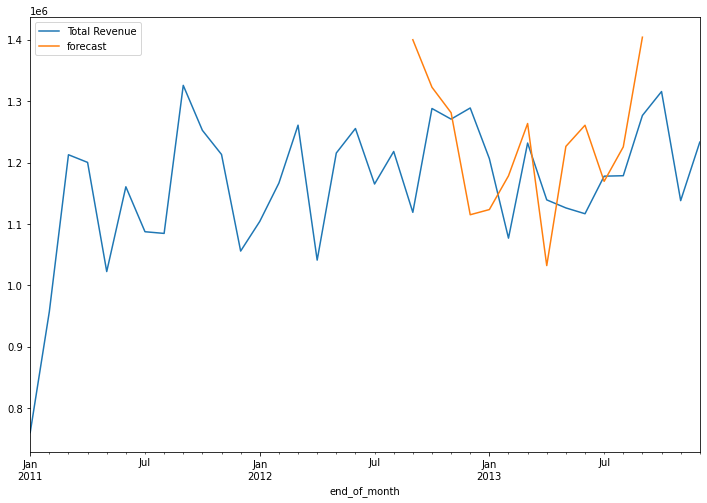

In [87]:
data = st_grouped.copy()
data['forecast']=results.predict(start=20,end=32,dynamic=True)
data[['Total Revenue','forecast']].plot(figsize=(12,8))

In [89]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1]+ DateOffset(months=x)for x in range(0,13)]

In [90]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
data=pd.concat([data,pred_date])

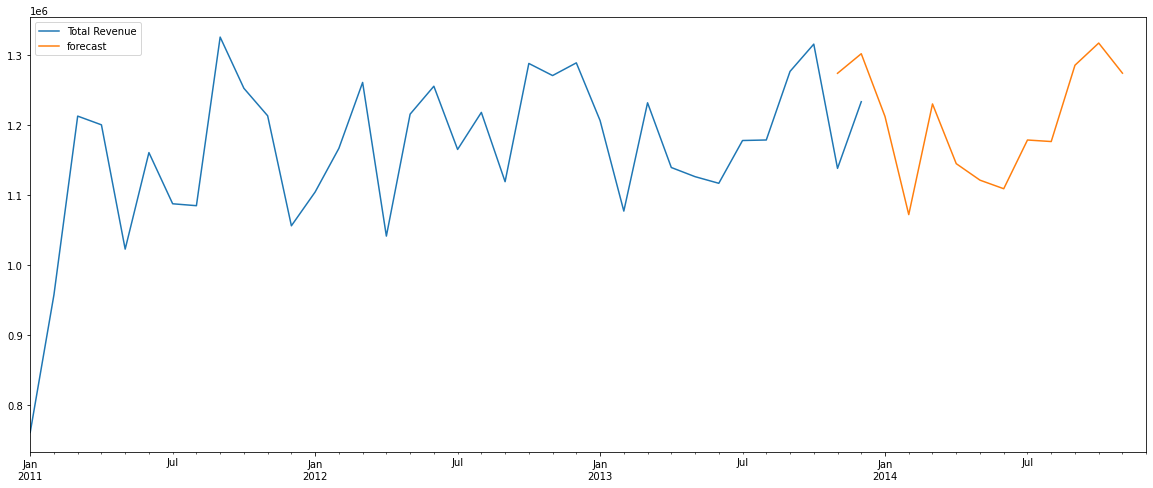

In [91]:
data['forecast'] = results.predict(start = 34, end = 46, dynamic= True)  
data[['Total Revenue', 'forecast']].plot(figsize=(20, 8))